# Задача 6. Компьютерное зрение: задача сегментации

* **Дедлайн**: 17.05.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

Обучаем Сегментацию:
- https://colab.research.google.com/drive/1eUIOnLFB_9_6CJ3dVZxY9TV_gCqDAmaV?authuser=1#scrollTo=SjKfL5X_RbzH --- тут мы обучали на большом датасете одну эпоху.
- https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view?usp=sharing --- тут лежит датасет который мы будем использовать.

Мы хотим обучить наш unet на небольшом датасете. Нужно заполнить репорт и сделать выводы.
Чтобы успеть сделать много экспериментов нужна видеокарта. Можно использовать colab, тут есть бесплатные gpu ресурсы --- так будет быстрее.


- [x] Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
- [x] Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
- [x] Попробовать улучшить качество изменяя архитектуру.
- [x] (**+2 балла**) Сделать train/test разбиение. Внутри train сделать 5fold, обучить 5 моделей. Построить кривые обучения для каждого фолда. Предсказать тест со всех 5 моделей и сагрегировать предсказания (до расчета метрик), сравнить с одной моделью обученной на всех данных. Сравнить с моделями обученными на фолдах. Сравнить плохие предсказания теста на разных фолдах. Ошибается на одних и тех же семплах или на разных?
- [x] (**+3 балла**) Сделать unet с pretrained энкодером (можно взять vgg или resnet18/34), сравнить с предыдущими пунктами.

In [ ]:
%pip install opencv-python
%pip install torchmetrics -U
%pip install pandas seaborn numpy torchvision tqdm scikit-learn
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install gdown

In [ ]:
import copy
import random
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
import torch
import torch.utils.data
import torchmetrics
from matplotlib import pyplot as plt
from torch import nn
from torchvision import io
from torchvision import transforms
from torchvision.transforms import functional, Resize
from tqdm.auto import tqdm, trange
import seaborn as sns
from collections import defaultdict
import torch.nn as nn
from IPython.display import clear_output
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader

In [ ]:
def reset_seed(seed=777):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

# Dataset

In [ ]:
!gdown 11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe
!unzip dataset.zip

In [5]:
import torchvision.transforms as tr
transform_image = tr.Compose([
    tr.ToPILImage(),
    tr.Resize((800, 600)),
    tr.ToTensor(),
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, masks, transform=transform_image):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        img = self.transform(io.read_image(str(self.images[item])) / 255)
        mask = self.transform(io.read_image(str(self.masks[item])) / 255)
        return img, mask

Train size:  1700
Test size:  300
torch.Size([3, 800, 600])
torch.Size([1, 800, 600])


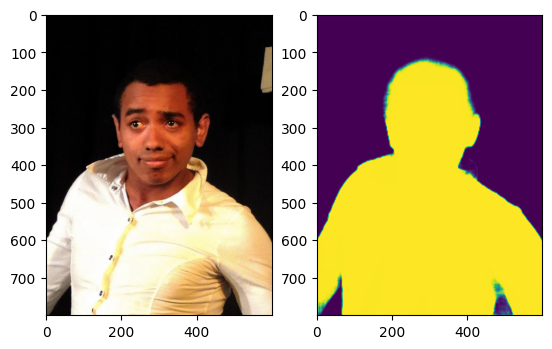

In [6]:
reset_seed()

def show_images(image, mask):
    _, ax = plt.subplots(1, 2)
    ax[0].imshow(functional.to_pil_image(image))
    ax[1].imshow(functional.to_pil_image(mask))
    plt.show()


image_paths = np.array(sorted(Path("dataset/images").iterdir()))
mask_paths = np.array(sorted(Path("dataset/masks").iterdir()))
random_mask = np.random.choice(len(image_paths), size=len(image_paths), replace=True)
image_paths, mask_paths = image_paths[random_mask], mask_paths[random_mask]
train_size = 0.85
split_index = int(len(image_paths) * train_size)
train_dataset = Dataset(
    images=image_paths[:split_index],
    masks=mask_paths[:split_index],
)
test_dataset = Dataset(
    images=image_paths[split_index:],
    masks=mask_paths[split_index:],
)

print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))

image, mask = train_dataset[777]
print(image.shape)
print(mask.shape)
show_images(image, mask)

# U-Net

In [57]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()
        self.seq_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.seq_block(x)


class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
        super(CNNBlocks, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(n_conv):
            self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
            in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()
        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers.extend([
                CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                nn.MaxPool2d(2, 2)
            ])
            in_channels = out_channels
            out_channels *= 2

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            x = layer(x)
            if isinstance(layer, CNNBlocks):
                connections.append(x)

        return x, connections


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()
        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for _ in range(n_up):
            self.layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)
            ])
            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                dim_4 = connections_current.size(3) - x.size(3)
                dim_3 = connections_current.size(2) - x.size(2)
                if dim_4 != 0 or dim_3 != 0:
                    x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
                x = torch.cat([x, connections_current], dim=1)

            x = layer(x)
        return x

class UNET(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 16, exit_channels = 1, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(
            in_channels=out_channels * (2 ** n_down),
            out_channels=out_channels * (2 ** (n_down - 1)),
            exit_channels=exit_channels,
            padding=padding,
            n_up=n_down
        )

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

# Обучение

In [8]:
device = "cuda:0"
criterion = nn.BCEWithLogitsLoss()
jaccard = torchmetrics.classification.BinaryJaccardIndex().to(device)

def jaccard_index(pred, y):
    return jaccard(pred, y > jaccard.threshold)

def train(model, optimizer, loader, criterion, metric):
    model.train()
    train_losses = []
    train_metrics = []

    for img_batch, mask_batch in tqdm(loader, desc="Training"):
        img_batch, mask_batch = img_batch.cuda(), mask_batch.cuda()
        pred = model(img_batch)
        loss = criterion(pred, mask_batch)
        metr = metric(pred, mask_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_metrics.append(metr.item())
    


    return model, optimizer, np.mean(train_losses), np.mean(train_metrics)

def val(model, loader, criterion, metric):
    model.eval()
    val_losses = []
    val_metrics = []

    with torch.no_grad():
        for img_batch, mask_batch in tqdm(loader, desc="Validation"):
            img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)
            pred = model(img_batch)
            loss = criterion(pred, mask_batch)
            metr = metric(pred, mask_batch)

            val_losses.append(loss.item())
            val_metrics.append(metr.item())

    return np.mean(val_losses), np.mean(val_metrics)

def learning_loop(model, optimizer, train_loader, val_loader, criterion, epochs=10, val_every=1, draw_every=1, metric=jaccard_index):
    losses = {'train': [], 'val': []}
    metrics = {'train': [], 'val': []}

    for epoch in range(1, epochs + 1):
        print(f'#{epoch}/{epochs}:')

        model, optimizer, train_loss, train_metric = train(model, optimizer, train_loader, criterion, metric)
        losses['train'].append(train_loss)
        metrics['train'].append(train_metric)

        if epoch % val_every == 0:
            val_loss, val_metric = val(model, val_loader, criterion, metric)
            losses['val'].append(val_loss)
            metrics['val'].append(val_metric)

        if epoch % draw_every == 0:
            clear_output(wait=True)
            fig, axes = plt.subplots(1, 2, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            axes[0].plot(losses['train'], 'r.-', label='Train Loss')
            axes[0].plot(losses['val'], 'g.-', label='Val Loss')
            axes[0].set_title('Losses')
            axes[0].grid(True)
            axes[0].legend()

            axes[1].plot(metrics['train'], 'r.-', label='Train Jaccard')
            axes[1].plot(metrics['val'], 'g.-', label='Val Jaccard')
            axes[1].set_title('Jaccard Index')
            axes[1].grid(True)
            axes[1].legend()

            plt.show()

    return model, optimizer, losses, metrics

# Переобучение на батче

In [9]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dataset, range(batch_size)),
    batch_size=batch_size,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dataset, range(batch_size)),
    batch_size=batch_size,
)

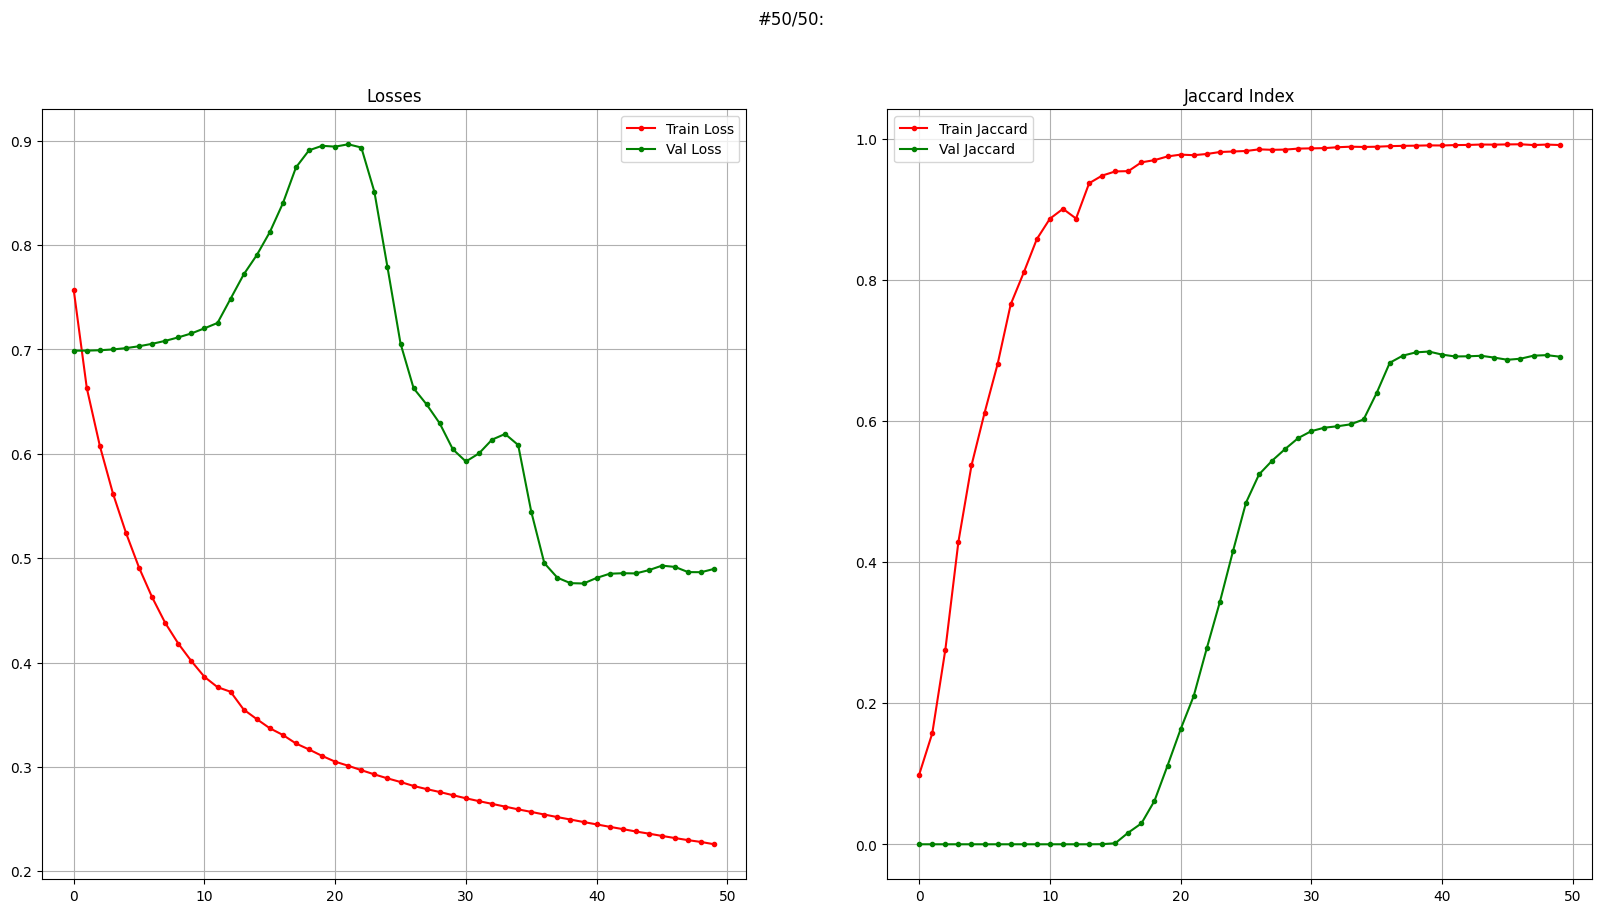

In [14]:
model = UNET(3, 16, 1).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _, _ = learning_loop(
    model, optimizer, train_loader, test_loader, criterion,
    epochs=50
)

Хорошие результаты на тренировке, но на тестах не очень - произошло переобучение.

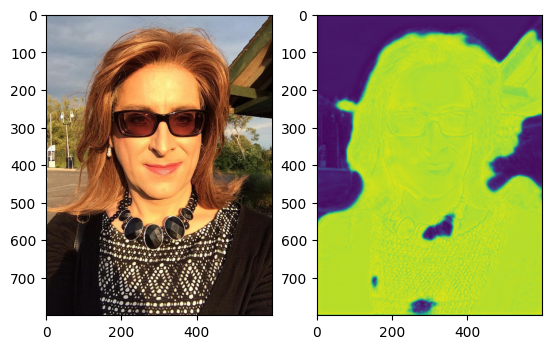

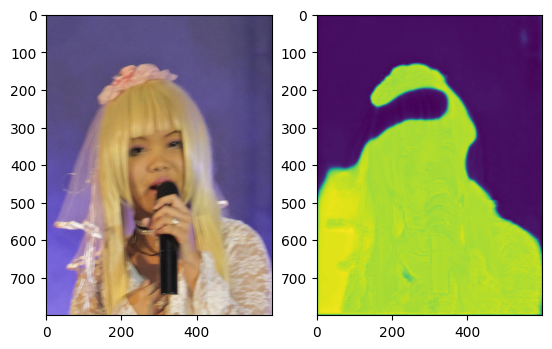

In [15]:
model.eval()

X, y = train_dataset[0]
with torch.no_grad():
    pred = model(X.to(device).unsqueeze(0))[0].cpu()
show_images(X, nn.functional.sigmoid(pred))

X, _ = test_dataset[0]
with torch.no_grad():
    pred = model(X.to(device).unsqueeze(0))[0].cpu()
show_images(X, nn.functional.sigmoid(pred))

# Полное обучение

In [31]:
batch_size = 8  

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

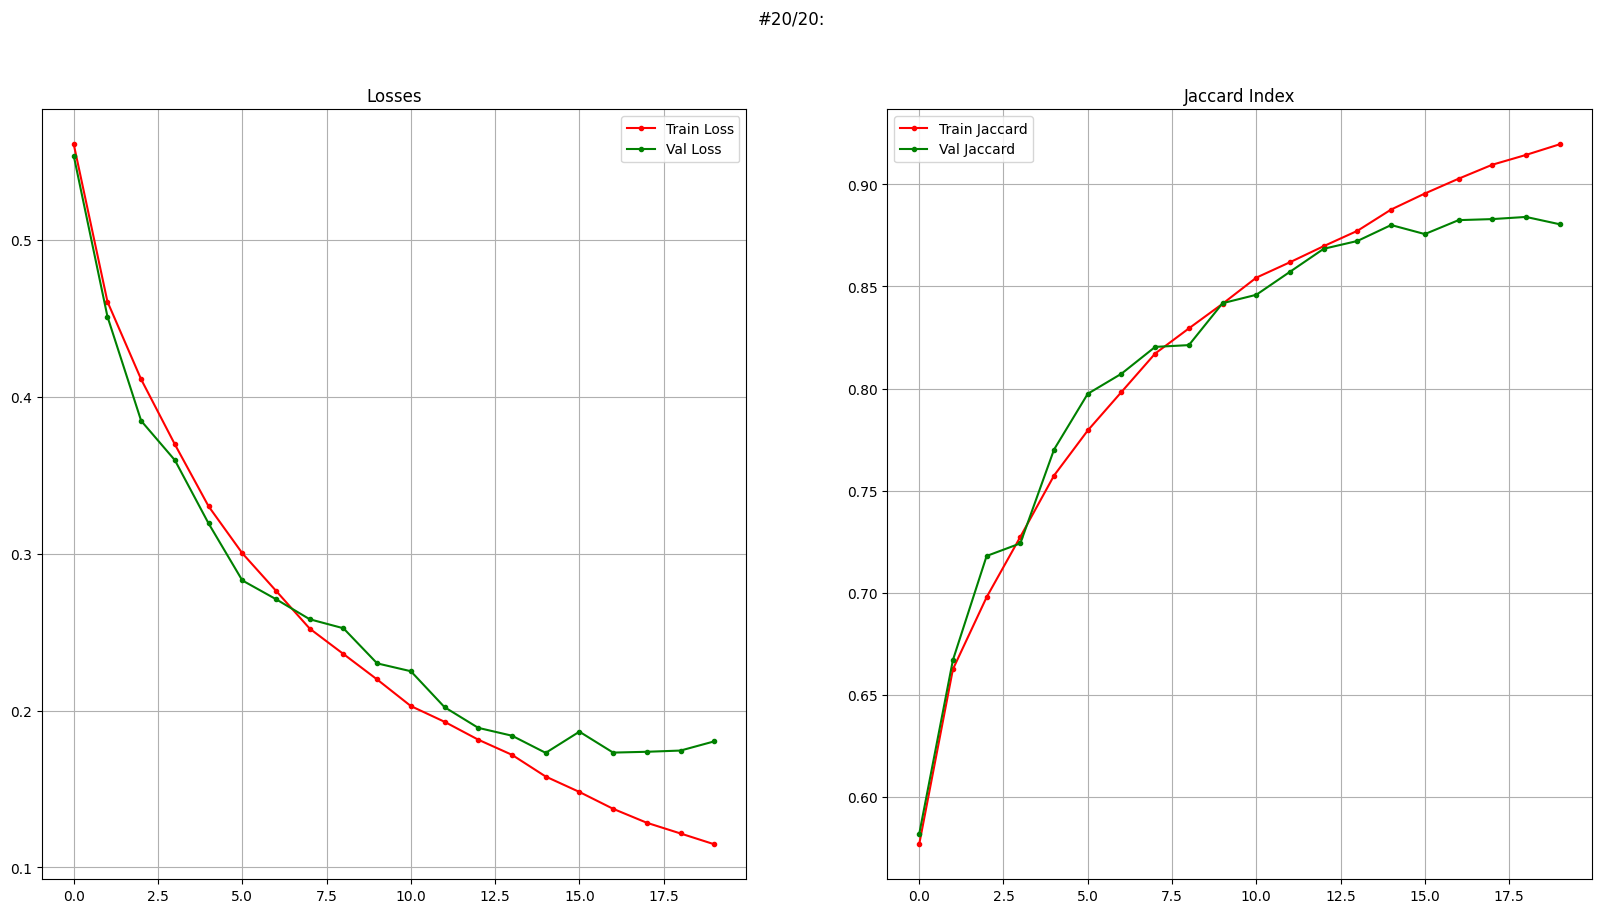

In [17]:
model = UNET(3, 16, 1).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _, _ = learning_loop(
    model, optimizer, train_loader, test_loader, criterion, 
    epochs=20
)

На графике заметны скачки, в целом неплохие результаты. На валидации Loss скачет к 0.2, а jaccard к 0.75. 

## Рассмотрим 3 худших (по jaccard index) результата

In [10]:
def show_worst_test_cases(model, n):
    test_metrics = []

    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataset):
            X = X.to(device).unsqueeze(0)
            y = y.to(device)
            pred = model(X)[0]
            jaccard_score = jaccard_index(pred, y).item()
            test_metrics.append((jaccard_score, i))

    worst_indices = [i for _, i in sorted(test_metrics)[:n]]

    with torch.no_grad():
        for i in worst_indices:
            X, _ = test_dataset[i]
            pred = model(X.to(device).unsqueeze(0))[0]
            show_images(X, nn.functional.sigmoid(pred))

    return worst_indices

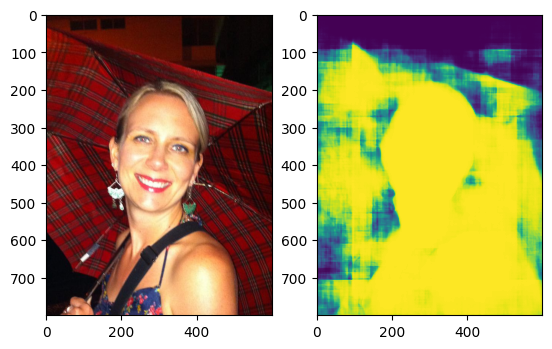

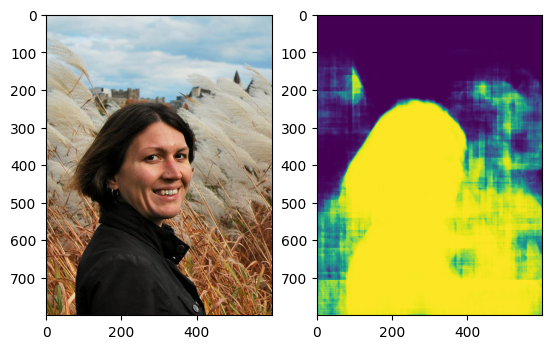

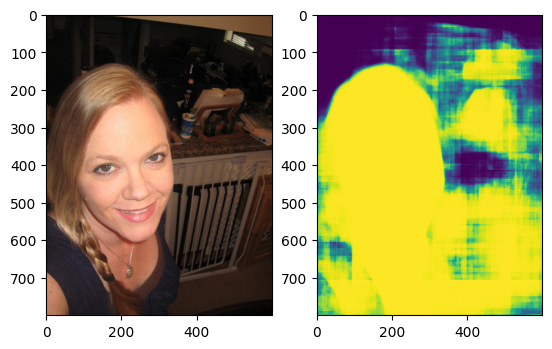

In [19]:
worst_idxs = show_worst_test_cases(model, 3)

Заметно, что модель плохо срабатывает на окружающей местности и предметах за кадром. 

# Аугментация

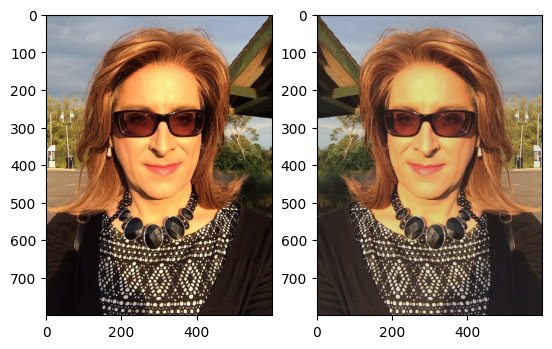

In [16]:
image_prepare = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(1),
])

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = image_prepare

image, _ = train_dataset[0]
augmented_image, _ = train_dataset_augmented[0]

show_images(image, augmented_image)

train_dataset_extended = torch.utils.data.ConcatDataset(
    [train_dataset, copy.copy(train_dataset_augmented)]
)
train_loader_extended = torch.utils.data.DataLoader(train_dataset_extended, batch_size=batch_size, shuffle=True)

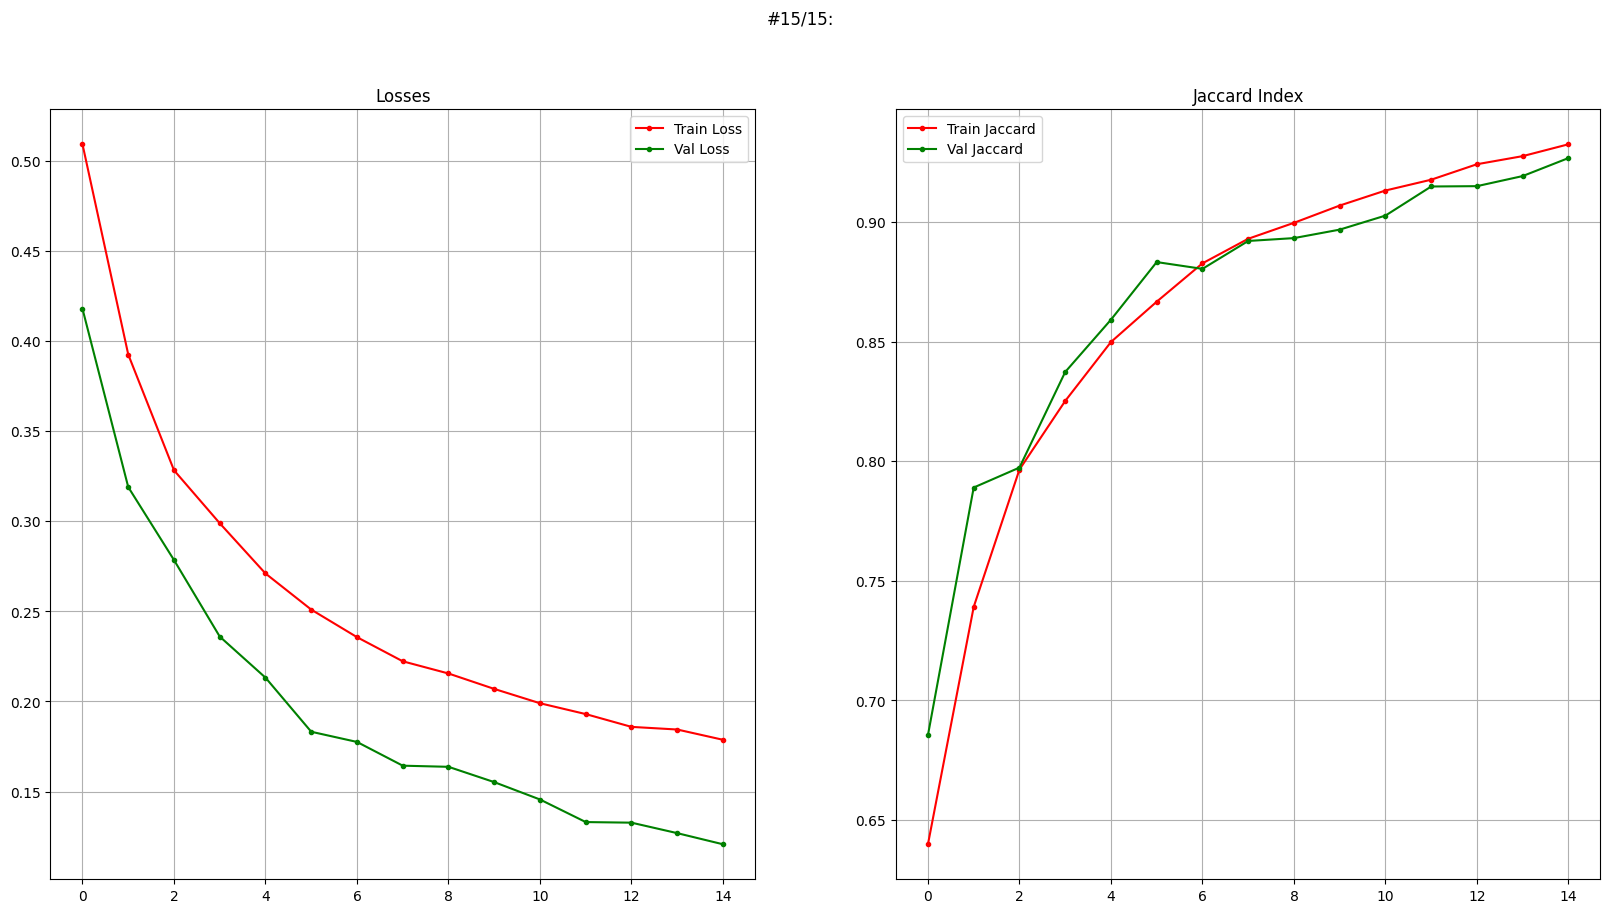

In [17]:
model = None
model = UNET(3, 16, 1).cuda()
optimizer = torch.optim.Adam(model.parameters())
model, _, _, _ = learning_loop(
    model, optimizer, train_loader_extended, test_loader, criterion, 
    epochs=15
)

С добавлением аугментации Loss на валидации справляется даже лучше, чем при трейне и стремится к 0,05. А jaccard index также хорошо проявляется и стремится к 0.96

# Test-time

In [18]:
class UNetHFlipWrapper(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 16, n_levels = 1):
        super().__init__()
        self.unet = UNET(in_channels, out_channels, n_levels)

    def forward(self, x):
        x = torch.cat([x, functional.hflip(x)])
        x = self.unet(x)
        x, x_alt = torch.chunk(x, 2)
        x_alt = functional.hflip(x_alt)
        stacked = torch.stack([x, x_alt])
        means = torch.mean(stacked, dim=0)
        return means

In [19]:
wrapped_model = UNetHFlipWrapper().to(device)
wrapped_model.unet.load_state_dict(model.state_dict());

In [20]:
print("Flip-wrapped (loss, jaccard):", val(wrapped_model, test_loader, criterion, jaccard_index))
print("Default model (loss, jaccard):", val(model, test_loader, criterion, jaccard_index))

Validation: 100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


Flip-wrapped (loss, jaccard): (0.11442487020241587, 0.9320163209187357)


Validation: 100%|██████████| 38/38 [00:12<00:00,  3.03it/s]

Default model (loss, jaccard): (0.12075438624934147, 0.9267261922359467)


Через обертку с horizontal flip можно заметить, что модель стала лучше, но всего на 0.01 к каждой метрике.

# VGG encoder

In [71]:
from torchvision import models
vgg = models.vgg11(pretrained=True)
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [26]:
features = vgg.features
blocks = []
i = 0
prev_i = 0
while i < len(features):
    i += 1 
    if i == len(features) or isinstance(features[i], nn.Conv2d):
        blocks.append(features[prev_i:i])
        prev_i = i
for block in blocks: 
    print(block)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
)
Sequential(
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
)
Sequential(
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace=True)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [33]:
class CNNBlocks(nn.Module):
    def __init__(self, block):
        super(CNNBlocks, self).__init__()
        self.layers = block

    def forward(self, x):
        return self.layers(x)
    
class CNNBLOCKS(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBLOCKS, self).__init__()
          self.layers = nn.ModuleList([CNNBlock(in_channels if i == 0 else out_channels, out_channels, padding) for i in range(n_conv)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, blocks):
        super(Encoder, self).__init__()
        self.enc_layers = nn.ModuleList([CNNBlocks(block) for block in blocks])

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            x = layer(x)
            if isinstance(layer, CNNBlocks) and layer.layers[0].in_channels != layer.layers[0].out_channels:
                connections.append(x)
    
        return x, connections

class Decoder(nn.Module):
    def __init__(self, blocks, exit_channels):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()
        self.layers.extend([
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)
        ])

        for block in blocks[::-1]:
            out_channels, in_channels = block[0].in_channels, block[0].out_channels
            if out_channels != in_channels:
                self.layers.extend([
                    nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                    CNNBLOCKS(n_conv=2, in_channels=in_channels + out_channels, out_channels=out_channels, padding=1)
                ])
        
        self.layers.extend([
            nn.Conv2d(out_channels, exit_channels, kernel_size=1, padding=0),
            nn.ConvTranspose2d(exit_channels, exit_channels, kernel_size=3, padding=1, stride=2, output_padding=1)
        ])

    def forward(self, x, connections):
        for layer in self.layers:
            if isinstance(layer, CNNBLOCKS):
                connections_current = connections.pop(-1)
                dim_4 = connections_current.size(3) - x.size(3)
                dim_3 = connections_current.size(2) - x.size(2) 
                if dim_4 != 0 or dim_3 != 0:
                    x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
                x = torch.cat([x, connections_current], dim=1)
            x = layer(x)
        return x
    
class UNET(nn.Module):
    def __init__(self, exit_channels):
        super(UNET, self).__init__()
        self.encoder = Encoder(blocks)
        self.decoder = Decoder(blocks, exit_channels)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

Поскольку видеопамяти как в колабе, так и локально не хватало, пришлось проводить несколько раз очистку перед запуском тренировки.

In [ ]:
import gc
try:
    del optimizer
    del model
except:
    print(f'моделька уже удалена')
torch.cuda.empty_cache()
gc.collect()


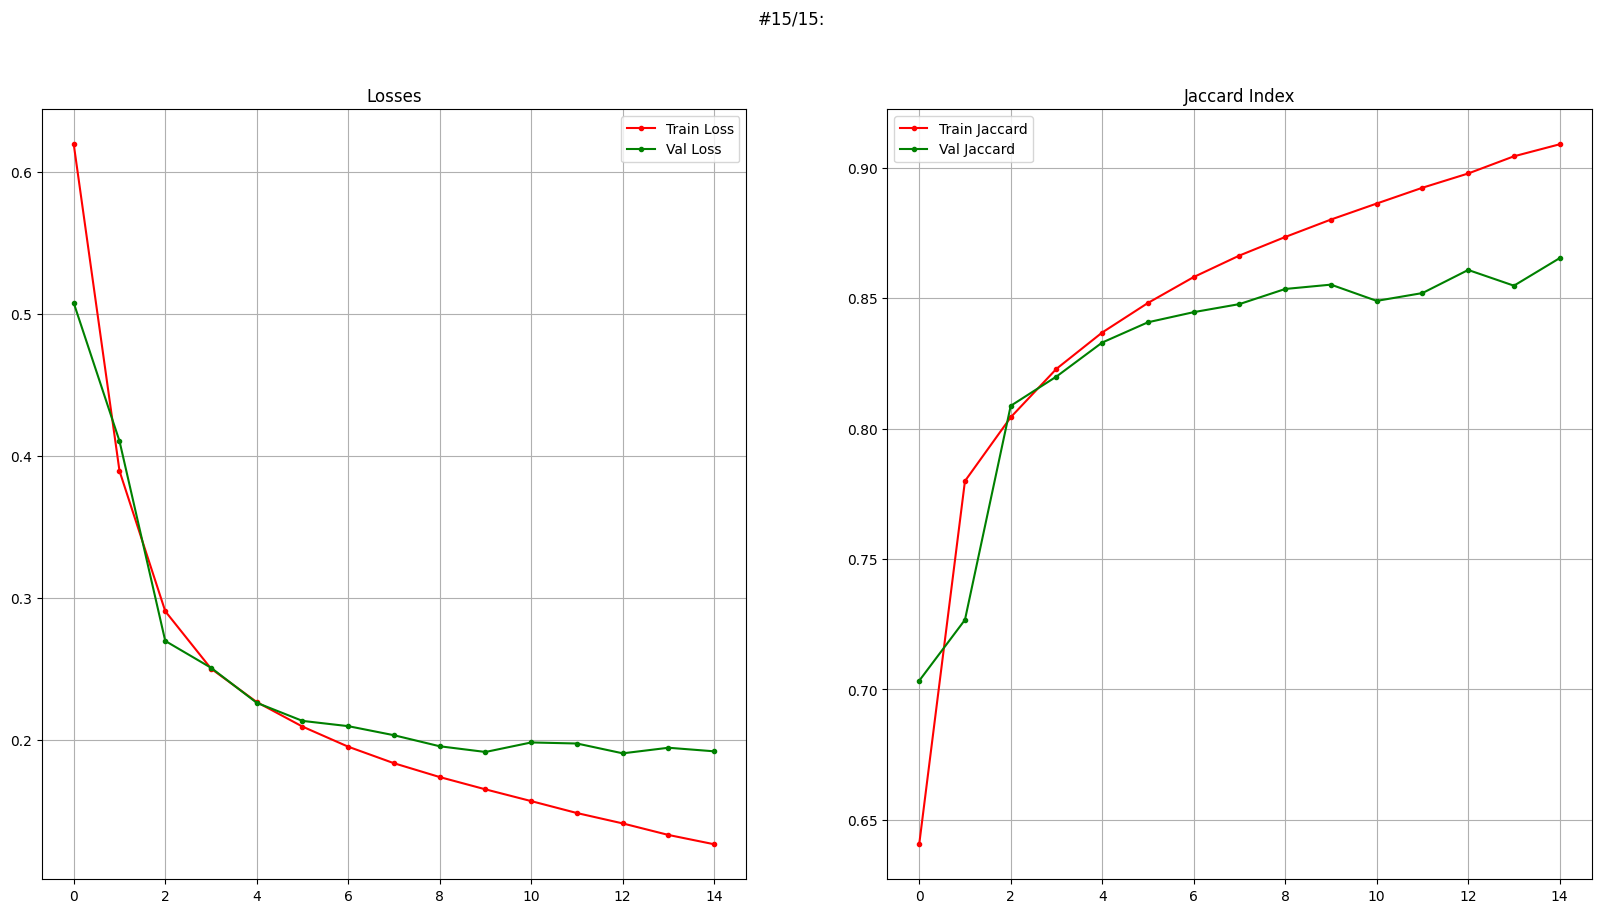

In [34]:
model = None
model = UNET(1).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _, _ = learning_loop(
    model, optimizer, train_loader, test_loader, criterion, 
    epochs=15
)

VGG показывает неплохие результаты, но при валидации метрики не сильно стремятся стать лучше

## VGG с замороженными весами

In [53]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()
          
          self.layers = nn.ModuleList()
          for _ in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()
        self.extractor = vgg.features[:5]
        for param in self.extractor.parameters():
            param.requires_grad = False
        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))
            self.enc_layers.append(nn.MaxPool2d(2, 2))

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        x = self.extractor(x)
        convt = nn.ConvTranspose2d(128, 16, kernel_size=2, stride=2).to(device)
        x = convt(x.to(device))
        for layer in self.enc_layers:
            x = layer(x)
            if isinstance(layer, CNNBlocks):
                connections.append(x)
          
        return x, connections

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for _ in range(n_up):
            self.layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2))
            self.layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                dim_4 = connections_current.size(3) - x.size(3)
                dim_3 = connections_current.size(2) - x.size(2) 
                if dim_4 != 0 or dim_3 != 0:
                    x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
                x = torch.cat([x, connections_current], dim=1)
            
            x = layer(x)
        return x
    
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(out_channels * (2 ** n_down),
                               out_channels * (2 ** (n_down - 1)),
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

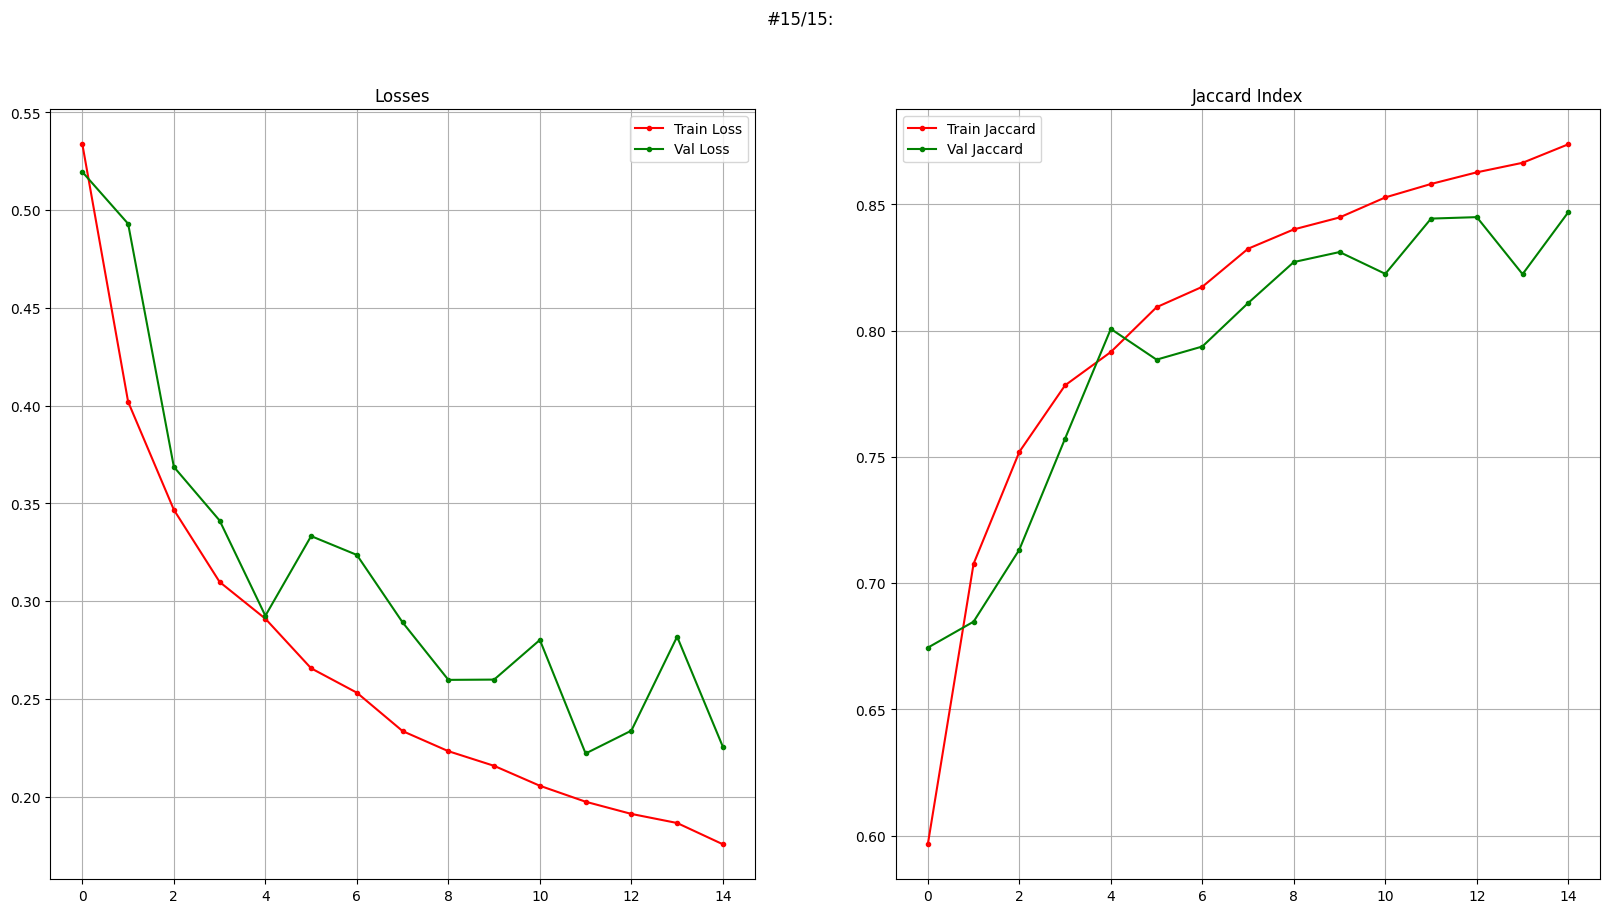

In [37]:
model = None
model = UNET(16, 16, 1, 4).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _, _ = learning_loop(
    model, optimizer, train_loader, test_loader, criterion, 
    epochs=15
)

Стало еще хуже, больше рывков и показатели слабее.

## VGG с размороженными весами

In [54]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()
        self.extractor = vgg.features[:5]
        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))
            self.enc_layers.append(nn.MaxPool2d(2, 2))

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        x = self.extractor(x)
        convt = nn.ConvTranspose2d(128, 16, kernel_size=2, stride=2).to(device)
        x = convt(x.to(device))
        for layer in self.enc_layers:
            x = layer(x)
            if isinstance(layer, CNNBlocks):
                connections.append(x)
        
        return x, connections

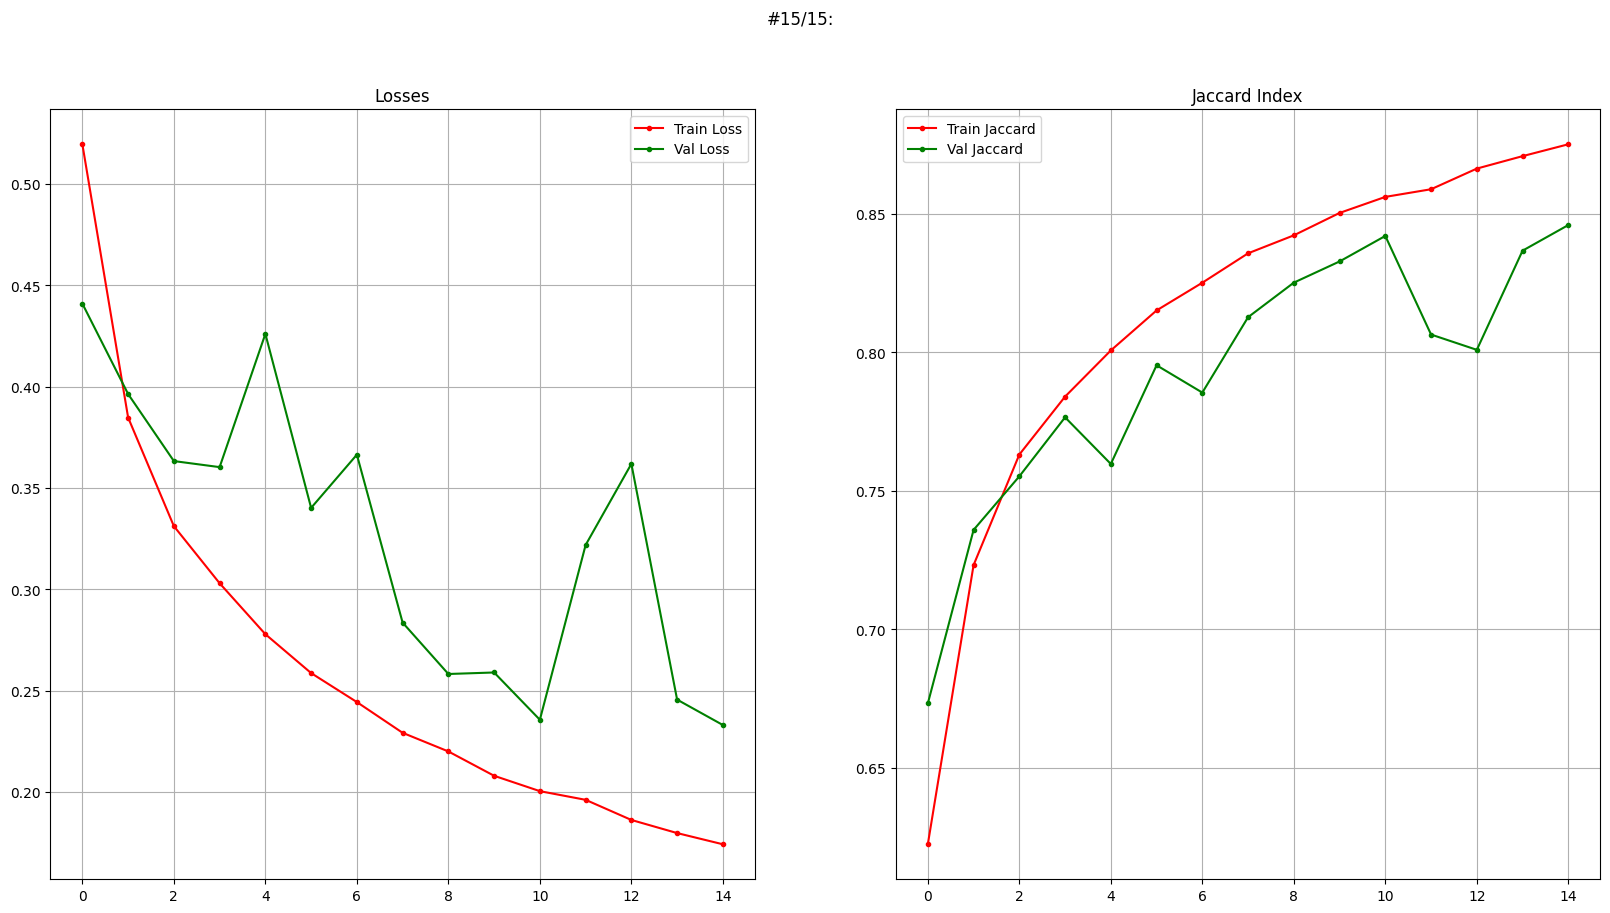

In [40]:
model = None
model = UNET(16, 16, 1, 4).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _, _ = learning_loop(
    model, optimizer, train_loader, test_loader, criterion, 
    epochs=15
)

Впринципе, также не сильно различаются от результатов vgg с замороженными весами.

# Cross-validation

In [59]:
kfold = KFold(n_splits=5)
train_folds, val_folds = [], []
tr_data = train_dataset

for fold,(train_idx,test_idx) in enumerate(kfold.split(tr_data)):
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(tr_data, batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(tr_data, batch_size=batch_size, sampler=test_subsampler)
    train_folds.append(trainloader)
    val_folds.append(testloader)
    
def run_kth_model(k, train_folds=train_folds, val_folds=val_folds):
    t = train_folds[k]
    tt = val_folds[k]

    mod = None
    mod = UNET(3, 16, 1).to(device)
    opt = torch.optim.Adam(mod.parameters())

    
    final, _, _, _ = learning_loop(mod, opt, t, tt, criterion)
    return final

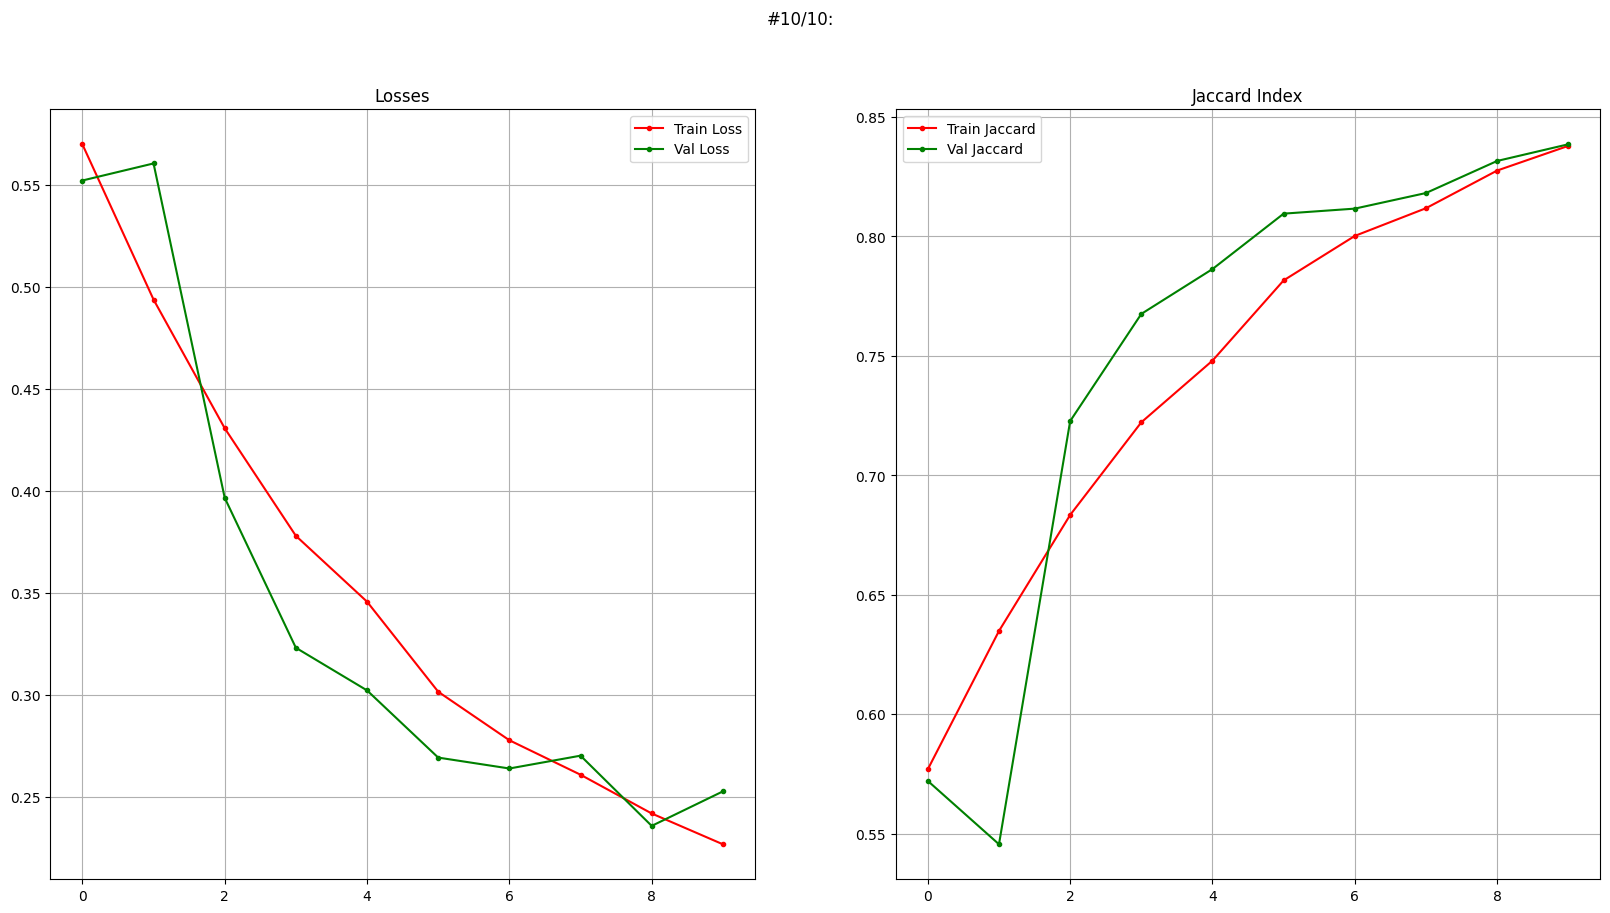

In [60]:
first_model = run_kth_model(0)

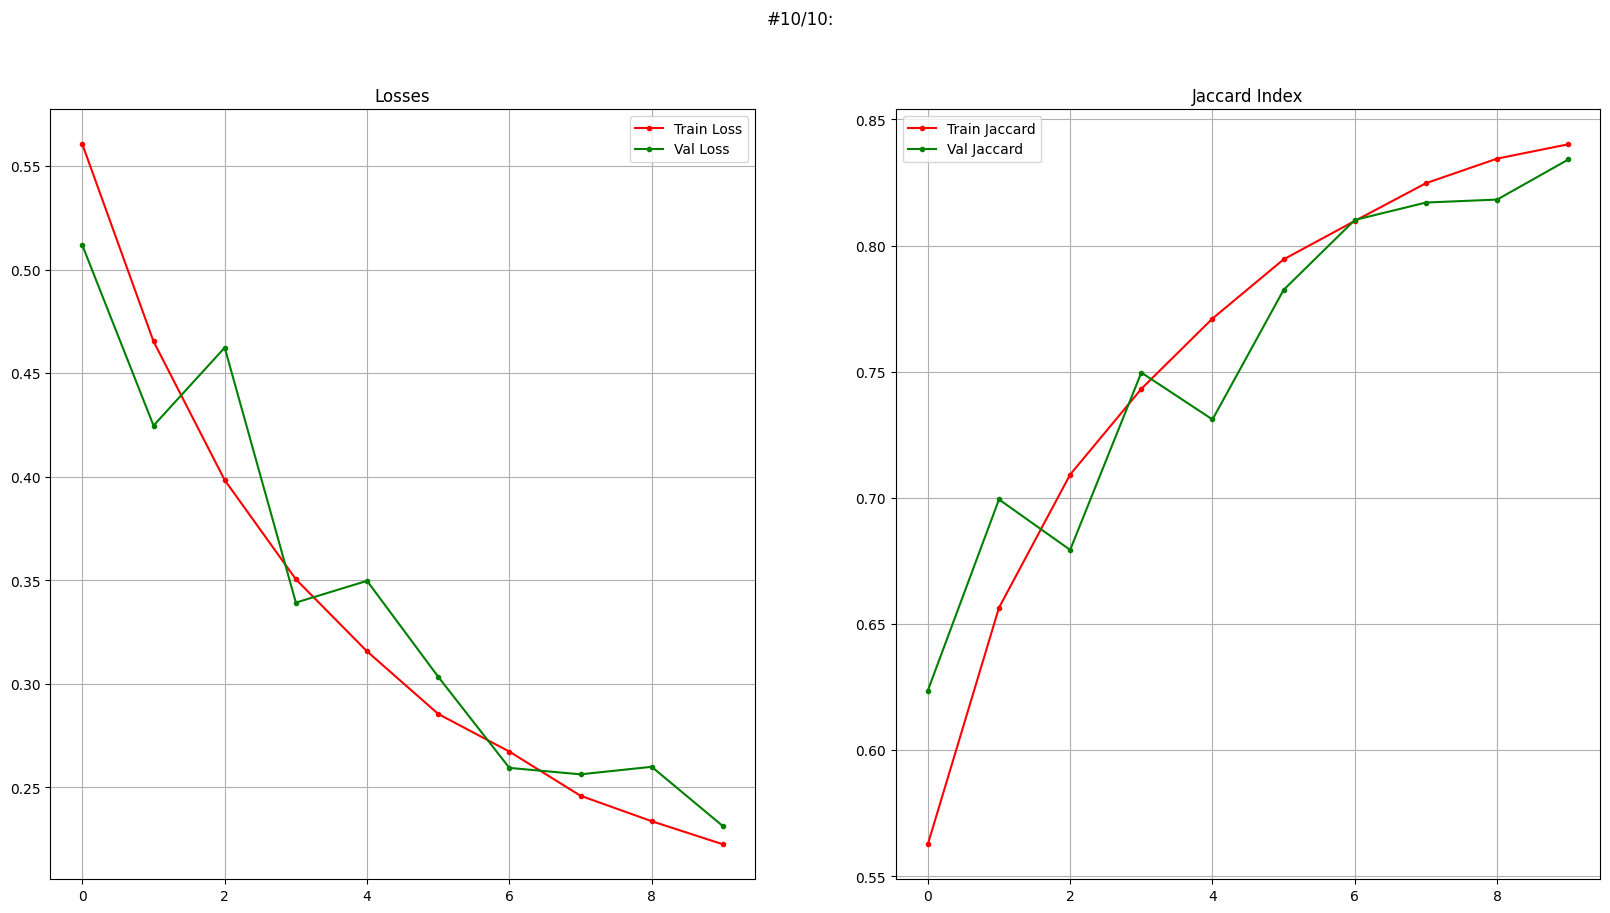

In [61]:
second_model = run_kth_model(1)

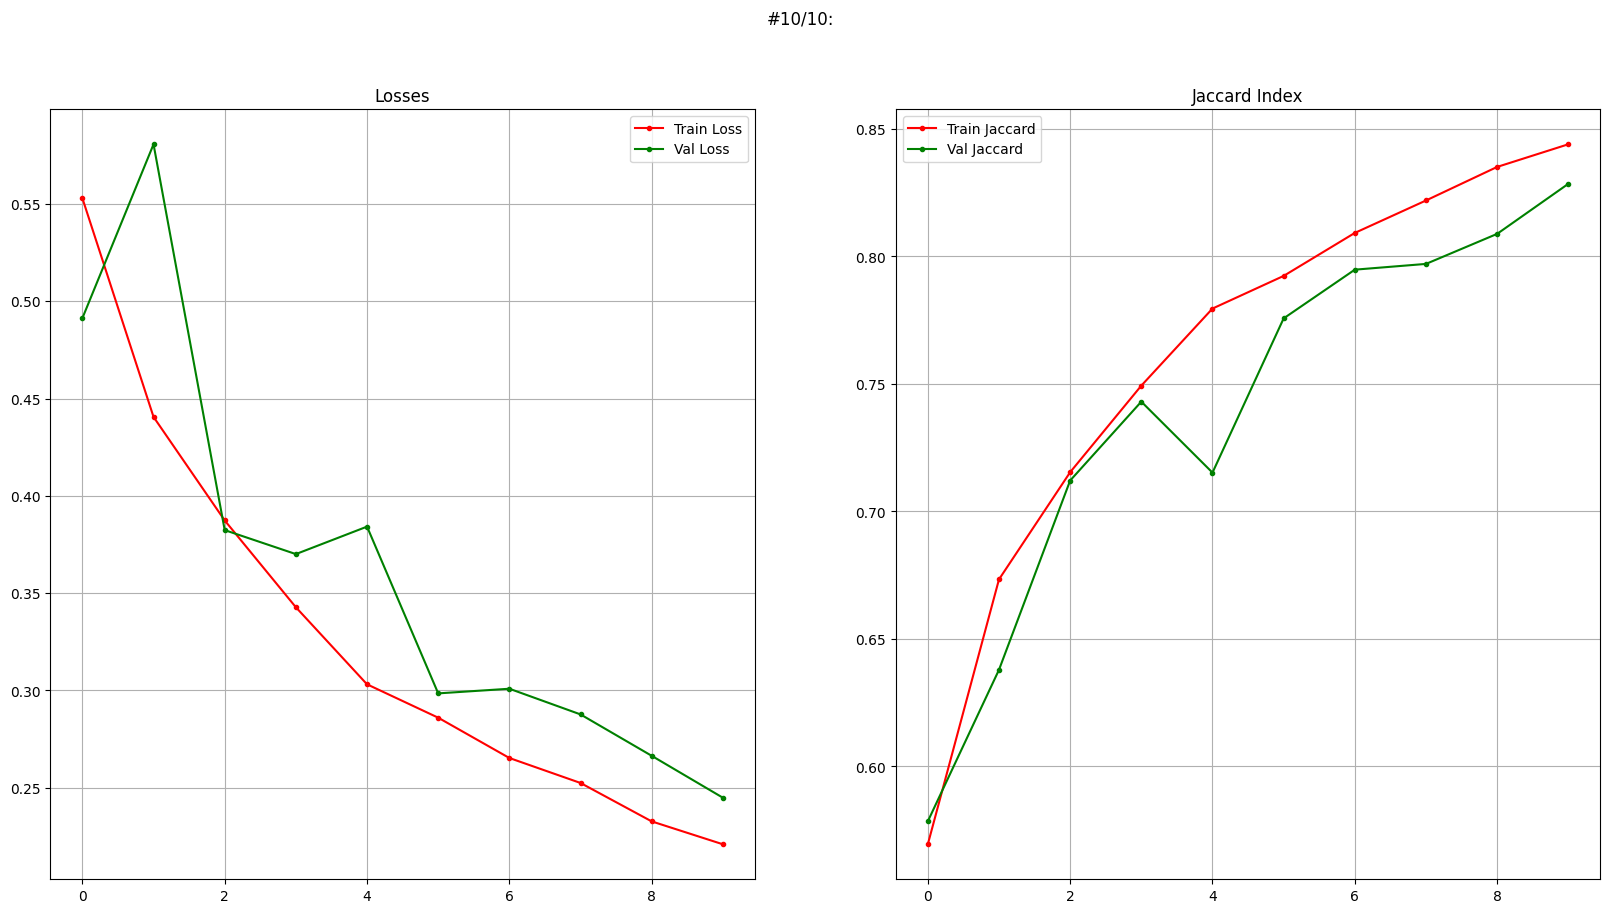

In [62]:
third_model = run_kth_model(2)

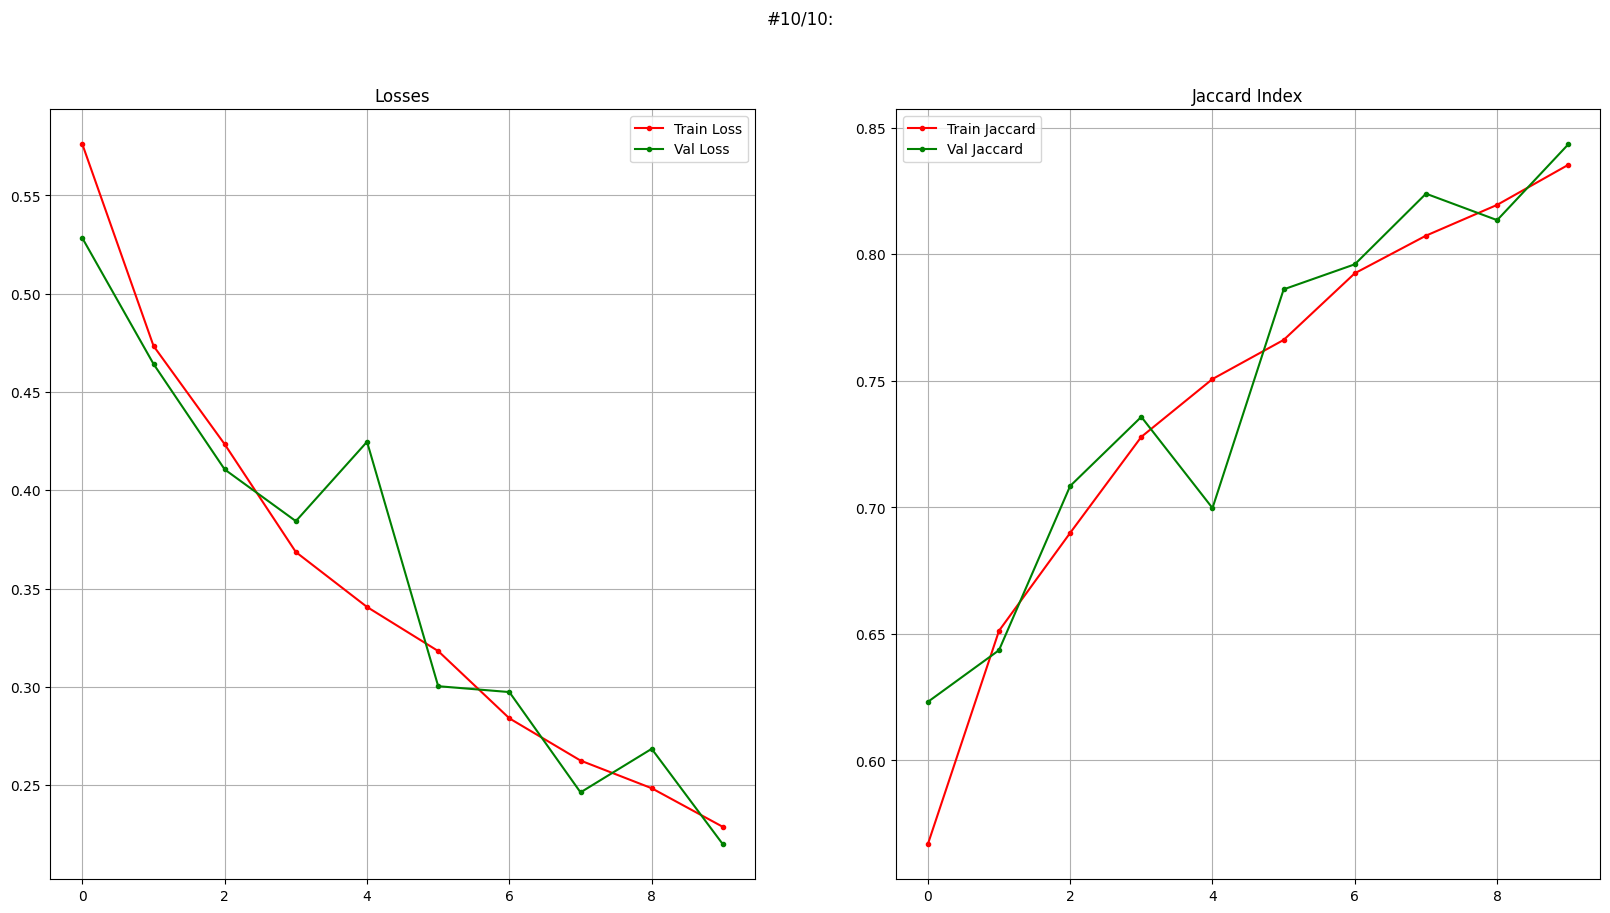

In [63]:
fourth_model = run_kth_model(3)

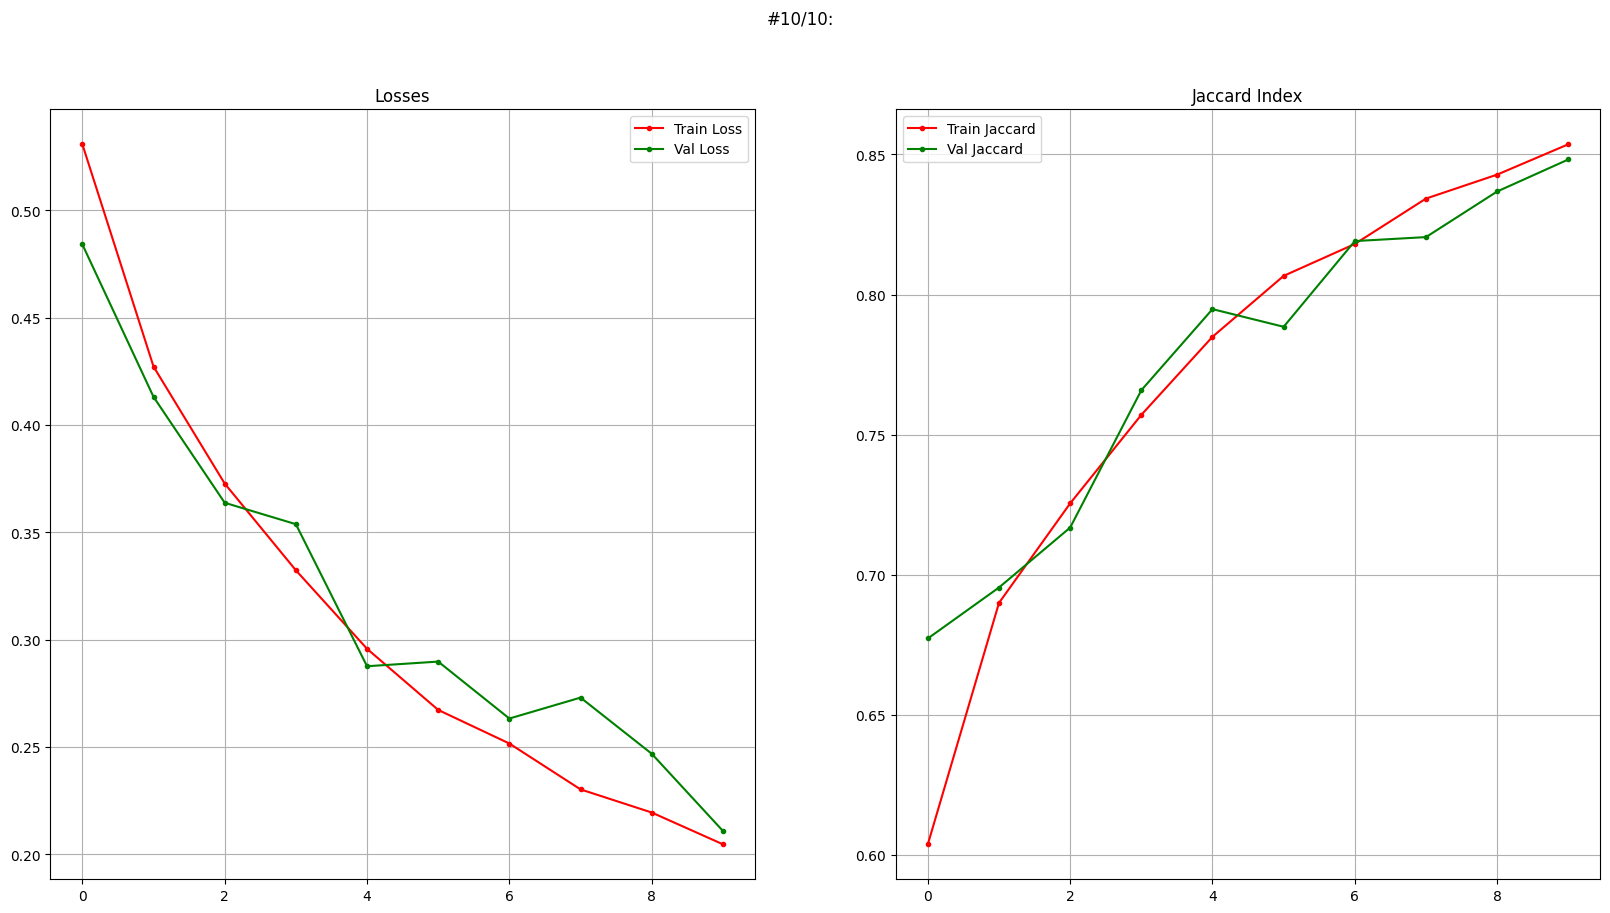

In [64]:
fifth_model = run_kth_model(4)

ывавыаывавыаыа

## Модели хорошо учатся с Foldами, посмотрим 3 плохих предсказаний

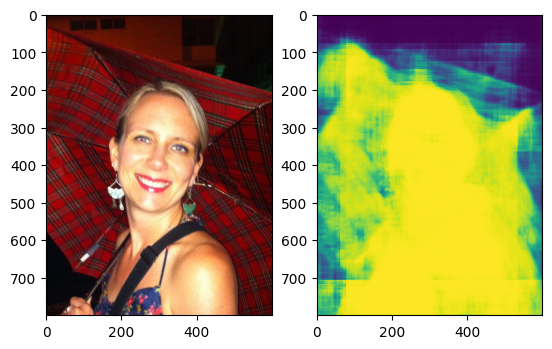

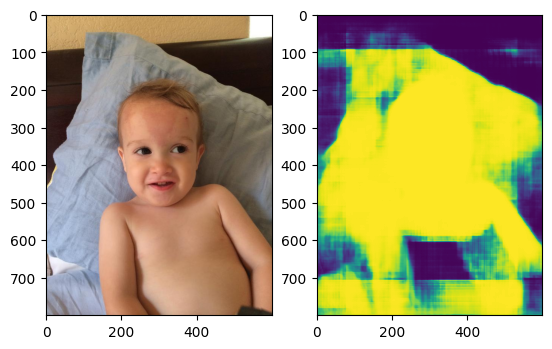

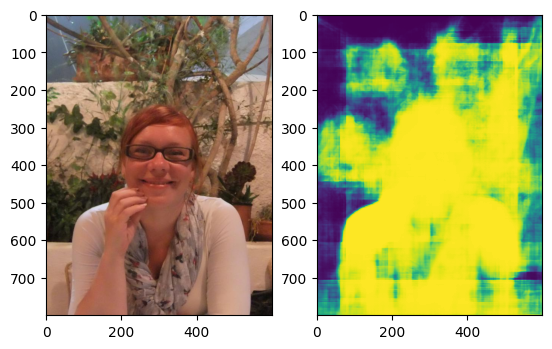

In [65]:
worst_idxs = show_worst_test_cases(first_model, 3)

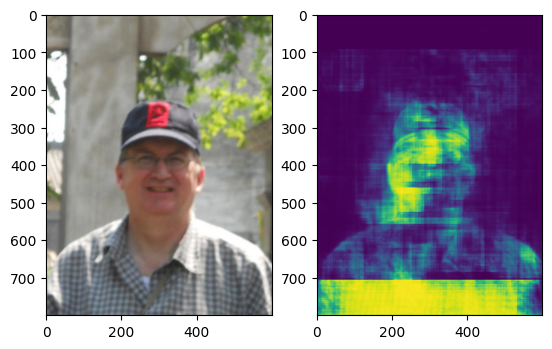

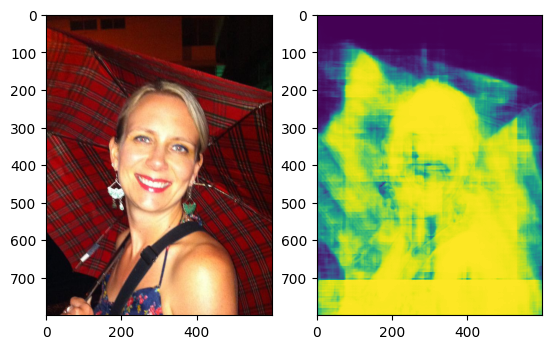

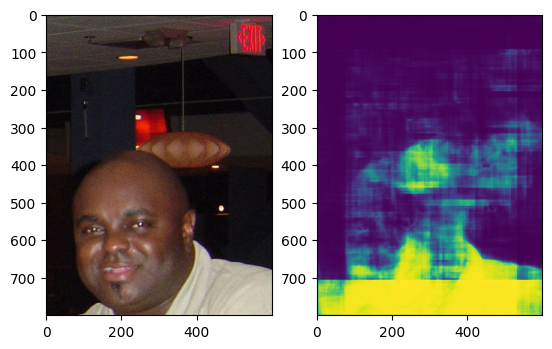

In [66]:
worst_idxs = show_worst_test_cases(second_model, 3)

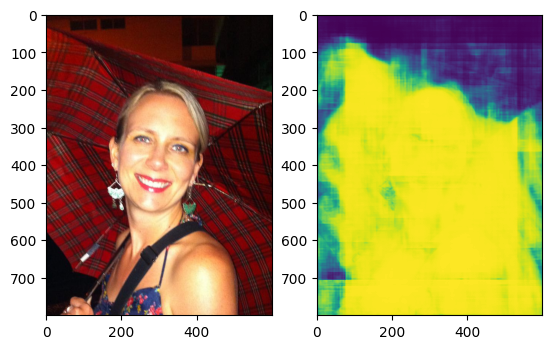

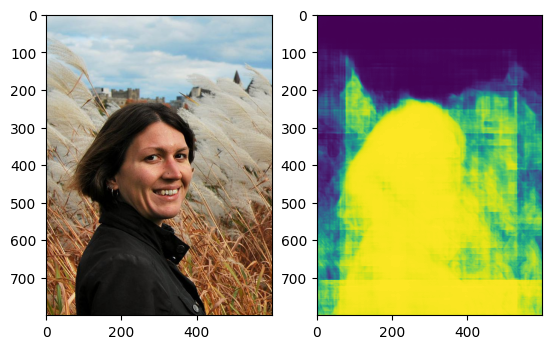

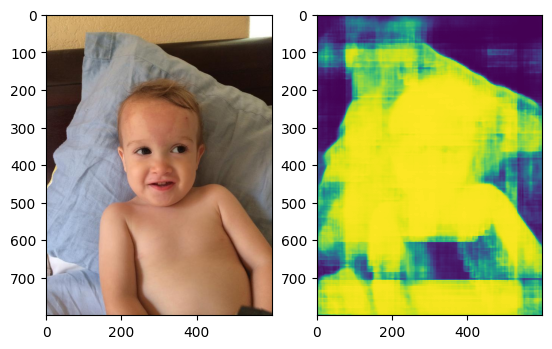

In [67]:
worst_idxs = show_worst_test_cases(third_model, 3)

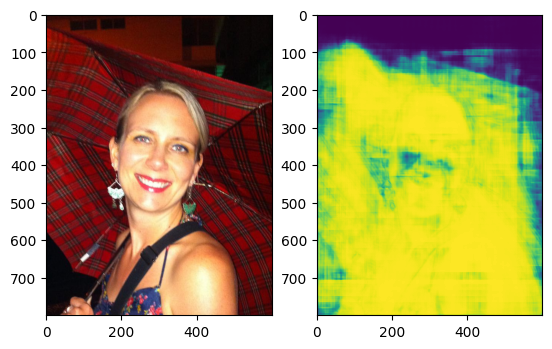

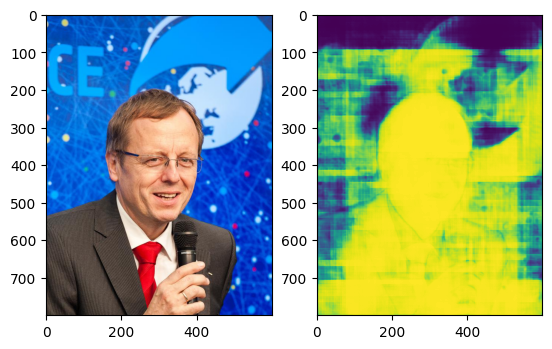

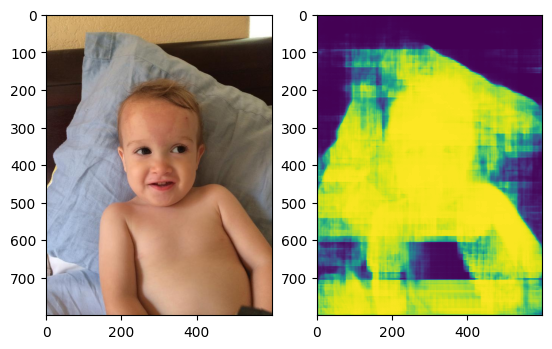

In [68]:
worst_idxs = show_worst_test_cases(fourth_model, 3)

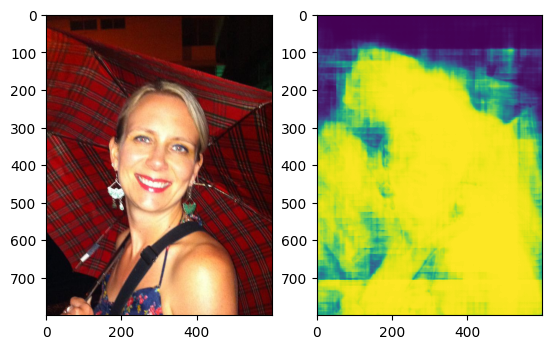

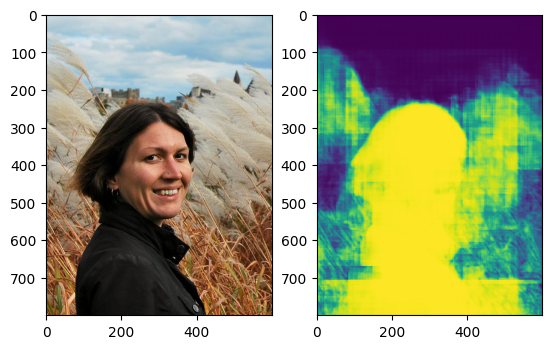

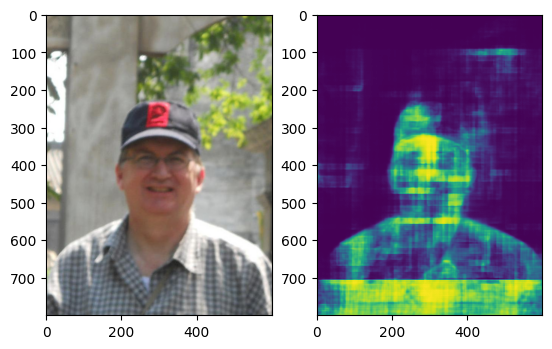

In [69]:
worst_idxs = show_worst_test_cases(fifth_model, 3)

Все модели примерно имеют схожий недостаток, они плохо справляются с тенями и объектами или окружением на заднем фоне. 

# Вывод

- Лучшие показатели получились у обычной UNET с аугментацией, также небольшой прирост дал horizontal flip.
- Test-time дал небольшой прирост на 0.1 к показателям
- Модели с vgg энкодером показали хужшие результаты
- Модели на фолдах плохо справляются с предметами и местностью на заднем фоне, но зато показали результаты лучше, чем у моделей с vgg.